<IPython.core.display.Javascript object>


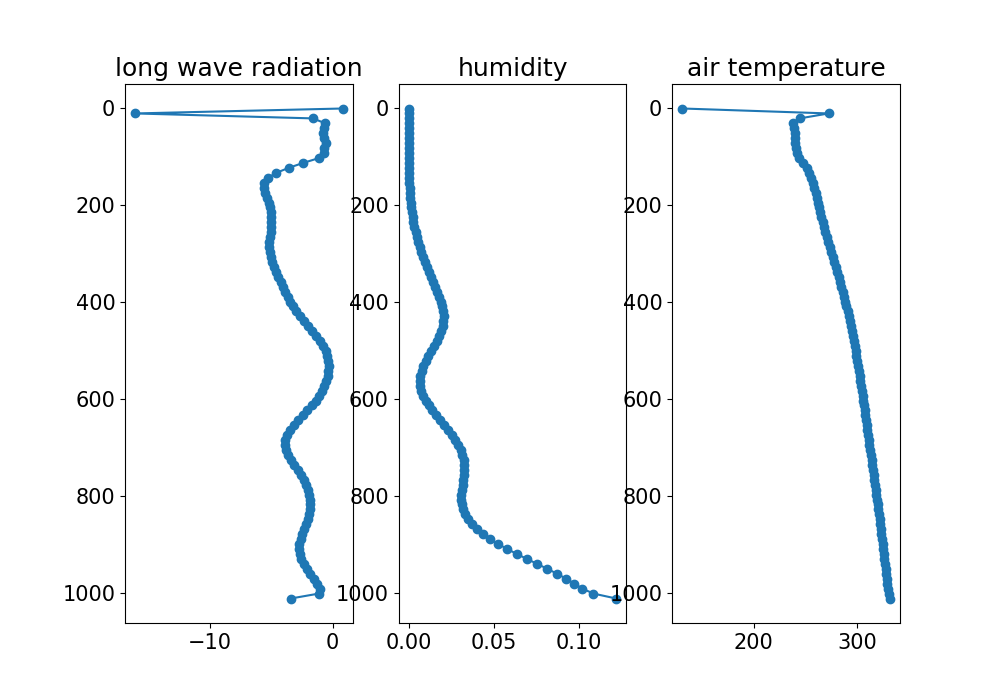

KeyboardInterrupt: 

In [1]:
%matplotlib notebook

from samples_generator import make_sample
from sympl import DataArray, PlotFunctionMonitor, RelaxationPrognostic, AdamsBashforth
from climt import SimplePhysics, get_default_state
import numpy as np
from datetime import timedelta
import random
import pickle
import os
from scipy.interpolate import CubicSpline
from climt import EmanuelConvection, RRTMGShortwave, RRTMGLongwave, SlabSurface
import time
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from copy import deepcopy
from sklearn.metrics import mean_squared_error

rcParams['figure.figsize'] = 10, 10
rcParams['font.size'] = 15


def cal_air_pressure(air_pressure_interface):
    air_pressure = np.empty(60)
    for level in range(len(air_pressure_interface) - 1):
        air_pressure[level] = (air_pressure_interface[level] + air_pressure_interface[level+1])*0.5
    return air_pressure


def plot_function(fig, state):
    fig.set_size_inches(10, 7)

    ax = fig.add_subplot(1, 3, 1)
    ax.plot(
        state['longwave_heating_rate'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o'
    )
    ax.set_title("long wave radiation")
    ax.axes.invert_yaxis()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(
        state['specific_humidity'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title("humidity")
    ax.axes.invert_yaxis()

    ax = fig.add_subplot(1, 3, 3)
    ax.plot(
        state['air_temperature'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title("air temperature")
    ax.axes.invert_yaxis()


def get_interface_pressures(p, ps):
    """Given 3D pressure on model mid levels (cell centers) and the 2D surface
    pressure, return the 3D pressure on model full levels (cell interfaces).
    If the z-dimension of p is length K, the returned p_full will have a
    z-dimension of length K+1."""
    interface_pressures = np.zeros(
        (p.shape[0], p.shape[1], p.shape[2] + 1), dtype=np.double)
    interface_pressures[:, :, 1:-1] = 0.5 * (p[:, :, 1:] + p[:, :, :-1])
    interface_pressures[:, :, 0] = ps[:, :]
    return interface_pressures


def initial_state():
    pressure, temps, abshum, relhum, ratm = make_sample()

    state = get_default_state([
        simple_physics, convection, radiation_lw, radiation_sw, slab
    ], mid_levels={
        'label': 'mid_levels',
        'values': np.arange(len(pressure)),
        'units': ''
    }, interface_levels={
        'label': 'interface_levels',
        'values': np.arange(len(pressure) + 1),
        'units': ''
    })

    state['surface_albedo_for_direct_shortwave'].values[:] = .5
    state['surface_albedo_for_direct_near_infrared'].values[:] = 0.5
    state['surface_albedo_for_diffuse_shortwave'].values[:] = 0.5
    state['zenith_angle'].values[:] = np.pi/3.
    state['ocean_mixed_layer_thickness'].values[:] = 50.
    state['area_type'].values[:] = 'sea'
    
    #state['air_pressure_on_interface_levels'].values[0, 0] = interface_pressure
    #state['air_pressure'].values[0, 0] = pressure    
    state['air_temperature'].values[0, 0] = temps[::-1]
    state['surface_temperature'].values[:] = ratm.get_temperature_by_altitude(0)
    state['specific_humidity'].values[0, 0] = abshum[::-1]
    
    return state


def simulate(state, timesteps=1000):
    monitor = PlotFunctionMonitor(plot_function)
    timestep = timedelta(minutes=10)

    equilibrium_value = DataArray(
        np.ones((1, 1, len(state['air_pressure']))) * 10,
        dims=('x', 'y', 'mid_levels'),
        attrs={'units': 'm s^-1'}
    )

    tau = DataArray(np.array(2.), dims=[], attrs={'units': 'hour'})

    relaxation = RelaxationPrognostic('eastward_wind', equilibrium_value, tau)
    time_stepper = AdamsBashforth([
        relaxation, convection, radiation_lw, radiation_sw, slab
    ])

    for i in range(timesteps):
        states = []
        convection.current_time_step = timestep
        diagnostics, state = time_stepper(state, timestep)
        state.update(diagnostics)

        new_state, diagnostics = simple_physics(state, timestep)
        state.update(diagnostics)
        monitor.store(state)

        state.update(new_state)
        state['eastward_wind'].values[:] = 6.


convection = EmanuelConvection()
radiation_sw = RRTMGShortwave()
radiation_lw = RRTMGLongwave()
slab = SlabSurface()
simple_physics = SimplePhysics(use_external_surface_specific_humidity=False)
        
simulate(initial_state())